## Testing several pre-trained CNN's to determine which one to use for the project

In [1]:
# for loading/processing the images and the models  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications import vgg16, resnet50, inception_v3, mobilenet, xception  
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

This code uses a dataset of 210 flower images to test the CNN's. Dataset is retreived from: https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images

In [2]:
# Change path
path = r"C:\Users\janin\flower_images\flower_images" 

os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

Select which models you want to compare

In [41]:
# modules = [vgg16, resnet50, inception_v3, mobilenet, xception]
# models = [vgg16.VGG16(), resnet50.ResNet50(), 
#           inception_v3.InceptionV3(), mobilenet.MobileNet(), 
#           xception.Xception()]

# List of models that will be used
modules = [vgg16, resnet50, mobilenet]
models = [vgg16.VGG16(), resnet50.ResNet50(), mobilenet.MobileNet()]

Function to extract the features from an image using a pretrained CNN

In [43]:
def extract_features(file, model, module):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = module.preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True, verbose=0)
    return features


Function for extracting the features and timing it. After that, a simple k-means cluster will be used to cluster the data. The inertia of the clusters will be calculated, which can be used to compare the CNN's.

In [44]:
def test_model(file, model, module):
    """Input model and returns time it takes to create the feature extraction vectors and
    a measure of accuracy when using kmeans on the feature extraction vectors"""

    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    
    data = {}
    
    start_time = time.time()

    # loop through each image in the dataset
    for flower in flowers:
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(flower,model,module)
            data[flower] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            print('Fail')
            pass
            
    end_time = time.time()
    time_taken = end_time - start_time

    # get a list of just the features
    feat = np.array(list(data.values()))

    # reshape so that there are 210 samples of x no. of vectors
    feat = feat.reshape(len(flowers),-1)


    # get the unique labels (from the flower_labels.csv)
    df = pd.read_csv('flower_labels.csv')
    label = df['label'].tolist()
    unique_labels = list(set(label))

    # reduce the amount of dimensions in the feature vector
    pca = PCA(n_components=100, random_state=22)
    
    try:
        pca.fit(feat)
    except:
        return np.nan, np.nan
    x = pca.transform(feat)

    kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
    kmeans.fit(x)
   
    sse = kmeans.inertia_

    return time_taken, sse

Run the for-loop over the different models for a certain number of iterations.
The time taken to extract the features and the inertia will be saved in a 2d array

In [45]:
iter = 5 # number of iterations
time_taken_arr = np.zeros((len(models), iter))
sse_arr = np.zeros((len(models), iter))

for m in range(len(models)):
    print(f'\nStart with new model: {m}')
    for i in range(iter):
        print(f'Iteration {i}')
        time_taken, sse = test_model(file, models[m], modules[m])
        time_taken_arr[m, i] = time_taken
        sse_arr[m, i] = sse


Start with new model: 0
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4

Start with new model: 1
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4

Start with new model: 2
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [46]:
time_taken_arr

array([[ 45.61501431,  44.17175293,  45.0232625 ,  64.05341983,
        102.97443271],
       [100.02671599, 100.61506724, 108.07975578, 103.00769377,
        106.55430722],
       [ 55.06615305,  56.02978396,  54.52557516,  57.10645628,
         53.23780918]])

In [47]:
sse_arr

array([[486793.4375  , 486793.4375  , 486793.4375  , 486793.4375  ,
        486793.4375  ],
       [ 67713.234375,  67713.234375,  67713.234375,  67713.234375,
         67713.234375],
       [506355.4375  , 506355.4375  , 506355.4375  , 506355.4375  ,
        506355.4375  ]])

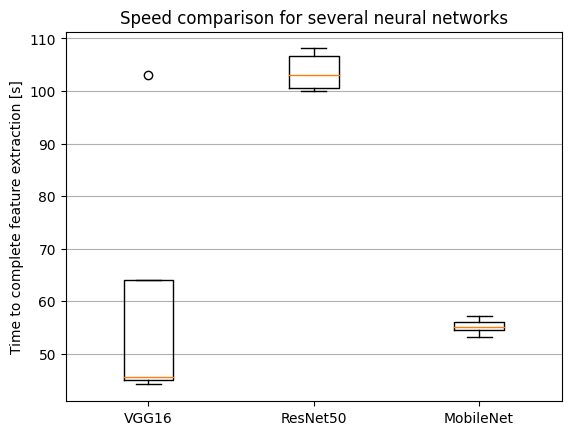

In [66]:
plt.boxplot(time_taken_arr.T)
plt.xticks([1, 2, 3], labels=['VGG16', 'ResNet50', 'MobileNet'])
plt.ylabel('Time to complete feature extraction [s]')
plt.title('Speed comparison for several neural networks')
plt.grid(axis='y')

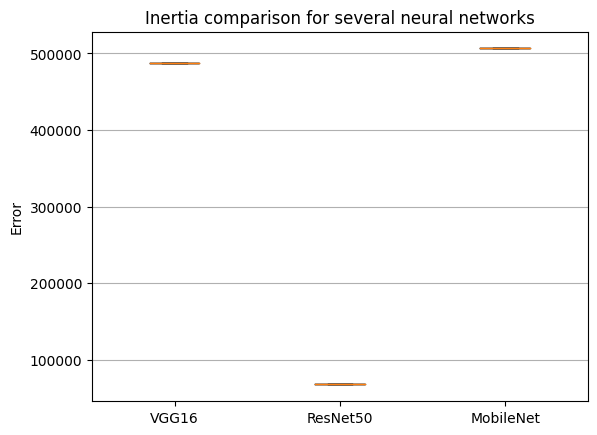

In [67]:
plt.boxplot(sse_arr.T)
plt.xticks([1, 2, 3], labels=['VGG16', 'ResNet50', 'MobileNet'])
plt.ylabel('Error')
plt.title('Inertia comparison for several neural networks')
plt.grid(axis='y')